In [65]:
import pandas as pd
import numpy as np

# Data Prepare

In [66]:
df = pd.read_csv("../datas/Hitters.csv")
df = df.dropna()
df.head(3)

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N


## Dummie

In [67]:
dms = pd.get_dummies(df[['League', 'Division', 'NewLeague']])
y = df["Salary"]
X = df.drop(['Salary', 'League', 'Division', 'NewLeague'], axis=1)
X = pd.concat([X, dms[["League_N", "Division_W", "NewLeague_N"]]], axis=1)

## Test Train

In [68]:
from sklearn .model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

# Reduce (Resize)

In [69]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [70]:
pca = PCA()

X_reduced_train = pca.fit_transform(scale(X_train))
print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)[:10])

X_reduced_test = pca.fit_transform(scale(X_test))
print(np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)[:10])

[38.18 59.88 70.88 78.88 84.18 88.45 92.05 94.86 96.34 97.28]
[39.74 62.29 71.86 80.34 86.24 90.47 93.78 95.85 97.04 97.8 ]


## Statsmodels

In [71]:
import statsmodels.api as sm
lm = sm.OLS(y_train, X_train)
model = lm.fit()
model.summary().tables[0]

Dep. Variable:,Salary,R-squared (uncentered):,0.830
Model:,OLS,Adj. R-squared (uncentered):,0.812
Method:,Least Squares,F-statistic:,45.84
Date:,"Mon, 17 Jan 2022",Prob (F-statistic):,2.81e-58
Time:,12:19:19,Log-Likelihood:,-1396.0
No. Observations:,197,AIC:,2830.
Df Residuals:,178,BIC:,2892.
Df Model:,19,,
Covariance Type:,nonrobust,,


# Sklearn

In [72]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
pcr_model = lm.fit(X_reduced_train, y_train)

# Predict

In [73]:
y_pred_train = pcr_model.predict(X_reduced_train)
y_pred_test = pcr_model.predict(X_reduced_test)

# Errors

In [74]:
from sklearn.metrics import mean_squared_error, r2_score

In [76]:
print(f"Train Mse: {np.sqrt(mean_squared_error(y_train, y_pred_train))}\n"
      f"Test Mse: {np.sqrt(mean_squared_error(y_test, y_pred_test))}\n"
      f"Train R2: {r2_score(y_train, y_pred_train)}\n"
      f"Test R2: {r2_score(y_test, y_pred_test)}")

Train Mse: 289.3292825564976
Test Mse: 405.1575364149965
Train R2: 0.5770075250410179
Test R2: 0.24170463640313256


# Model Tuning

In [82]:
from sklearn import model_selection

In [80]:
lm = LinearRegression()
pcr_model = lm.fit(X_reduced_train[:,0:10], y_train)
y_pred_test = pcr_model.predict(X_reduced_test[:,0:10])
np.sqrt(mean_squared_error(y_test, y_pred_test))

390.79142556822245

In [83]:
cv_10 = model_selection.KFold(n_splits=10, shuffle=True, random_state=1)

In [145]:
lm = LinearRegression()
RMSE = []
for i in range(1,X_reduced_train.shape[1]+1):
    score = np.sqrt(-1*model_selection.cross_val_score(lm,
                                                     X_reduced_train[:,:i],
                                                     y_train.ravel(),
                                                     cv=cv_10,
                                                     scoring='neg_mean_squared_error').mean())
    RMSE.append(score)

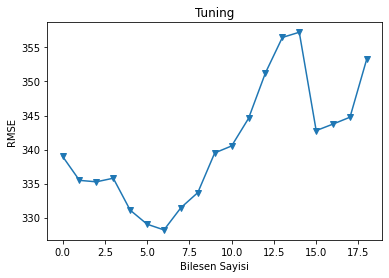

In [146]:
import matplotlib.pyplot as plt
plt.plot(RMSE, '-v')
plt.xlabel('Bilesen Sayisi')
plt.ylabel('RMSE')
plt.title('Tuning');

In [136]:
lm = LinearRegression()
RMSE_test = []
for i in range(1,X_reduced_test.shape[1]+1):
    pcr_model = lm.fit(X_reduced_train[:,0:i], y_train)
    y_pred_test = pcr_model.predict(X_reduced_test[:,0:i])
    score = np.sqrt(mean_squared_error(y_test, y_pred_test))
    RMSE_test.append(score)

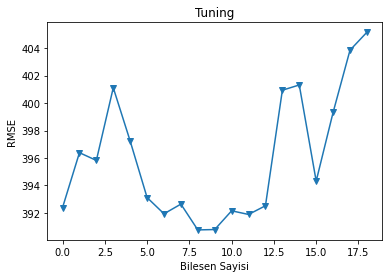

In [137]:
plt.plot(RMSE_test, '-v')
plt.xlabel('Bilesen Sayisi')
plt.ylabel('RMSE')
plt.title('Tuning');

# Final Model

In [147]:
lm = LinearRegression()
pcr_model = lm.fit(X_reduced_train[:,0:6], y_train)

In [148]:
y_pred_train = pcr_model.predict(X_reduced_train[:,0:6])
np.sqrt(mean_squared_error(y_train, y_pred_train))

308.8265983094501

In [151]:
y_pred_test = pcr_model.predict(X_reduced_test[:,0:6])
np.sqrt(mean_squared_error(y_test, y_pred_test))

393.1198700096223